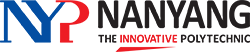

# IT2311 Assignment - Task 1a: Data Preparation

For this task, you are required to perform data understanding to examine your dataset and data cleaning to prepare the data for task 2 and 3.

Rename **DataPreparationStarter.ipynb** to **\<AdminNo\>_DataPreparation.ipynb** and complete the following sub-tasks:

Complete the following sub-tasks:

1. **Load Data**: Load your dataset
2. **Data Understanding**: Examine your dataset
3. **Data Cleaning**: Clean your data and perform all necessary pre-processing tasks
4. **Save Data**: Save the cleaned data for next task

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: Clifton Chen Yi, 231220B**

### Dataset Citation

Jordan, Luke S. (2021). *World Bank Project Documents* [Dataset]. Hugging Face.  
Available at: https://huggingface.co/datasets/lukesjordan/worldbank-project-documents

This dataset is shared under the **MIT +no-false-attribs (MITNFA) License**.  
Any modifications made to this dataset (e.g., filtering, cleaning, subsetting) were performed by **Clifton Chen Yi (231220B)** and are **not** endorsed by or attributed to the original author or the World Bank.

## Import Libraries and Download Packages

**Rationale:** We import the core libraries needed for data manipulation (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and natural language processing (`nltk`, `re`). NLTK resources such as stopwords, the Punkt tokenizer, and WordNet lemmatizer are downloaded for text preprocessing in later steps.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

print('All libraries imported and NLTK resources downloaded successfully.')

## 1. Load Data

**Rationale:** The dataset is stored in JSON Lines format (one JSON object per line). We use `pd.read_json()` with `lines=True` to load it into a pandas DataFrame. We display the first few rows immediately to verify the data has loaded correctly.

In [ ]:
# Load the World Bank projects dataset
df = pd.read_json('Task_1_TM_world_bank_projects_subset.json', orient='records', lines=True)

print(f'Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.')
df.head()

## 2. Data Understanding

**Rationale:** Before any cleaning or modelling, we must thoroughly understand the structure, quality, and characteristics of the data. This includes examining data types, missing values, duplicates, distributions of categorical and text fields, and basic statistics. These insights will guide our cleaning decisions.

### 2.1 Basic Structure

**Rationale:** Checking `.shape`, `.info()`, and `.dtypes` tells us the number of records, features, data types, and memory usage — the foundational facts about the dataset.

In [ ]:
# Shape of the dataset
print('Dataset Shape:', df.shape)
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
print()

# Data types and non-null counts
print('--- DataFrame Info ---')
df.info()
print()

# Column data types
print('--- Data Types ---')
print(df.dtypes)

### 2.2 Missing Values

**Rationale:** Missing values can affect analysis and modelling. We check both `NaN` values and empty strings because text fields may contain empty strings rather than `NaN`. Understanding the extent of missing data helps us decide whether to drop or impute.

In [ ]:
# Check for null / NaN values
print('--- Null Values per Column ---')
print(df.isnull().sum())
print()

# Check for empty strings in text columns
print('--- Empty Strings per Column ---')
for col in df.columns:
    if df[col].dtype == 'object':
        empty_count = (df[col].str.strip() == '').sum()
        print(f'{col}: {empty_count} empty strings')
print()

# Overall missing data percentage
print('--- Missing Data Percentage ---')
missing_pct = (df.isnull().sum() / len(df)) * 100
print(missing_pct)

### 2.3 Duplicate Records

**Rationale:** Duplicate records can bias analysis results (e.g., certain topics appearing more frequently than they actually do). We check for exact duplicates across all columns and also check for duplicate `project_id` values, since each project might have multiple documents (APPROVAL and REVIEW).

In [ ]:
# Check for exact duplicate rows
exact_duplicates = df.duplicated().sum()
print(f'Exact duplicate rows: {exact_duplicates}')

# Check for duplicate project_ids (not necessarily an error — each project can have APPROVAL and REVIEW docs)
duplicate_project_ids = df['project_id'].duplicated().sum()
print(f'Duplicate project_id entries: {duplicate_project_ids}')
print(f'Unique project_ids: {df["project_id"].nunique()}')
print()

# Show projects that have multiple documents
project_doc_counts = df.groupby('project_id').size().reset_index(name='doc_count')
multi_doc_projects = project_doc_counts[project_doc_counts['doc_count'] > 1]
print(f'Projects with multiple documents: {len(multi_doc_projects)}')
print(multi_doc_projects.head(10))

### 2.4 Document Type Distribution

**Rationale:** Understanding the distribution of document types (APPROVAL vs REVIEW) tells us if the dataset is balanced or skewed. This is important context for topic modelling — if one type dominates, the discovered topics may be biased toward that document type.

In [ ]:
# Value counts for document_type
print('--- Document Type Distribution ---')
print(df['document_type'].value_counts())
print()
print('--- Document Type Proportions ---')
print(df['document_type'].value_counts(normalize=True).round(4) * 100)

# Visualize the distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df['document_type'].value_counts().plot(kind='bar', color=['steelblue', 'coral'], edgecolor='black', ax=ax)
ax.set_title('Distribution of Document Types')
ax.set_xlabel('Document Type')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

### 2.5 Text Length Analysis

**Rationale:** Analyzing text length (in characters and words) helps identify potential issues such as very short documents (which may lack meaningful content for topic modelling) or extremely long documents (which may need truncation). This also reveals the general nature of the documents.

In [ ]:
# Calculate text length in characters and words
df['char_length'] = df['document_text'].str.len()
df['word_count'] = df['document_text'].str.split().str.len()

print('--- Text Length Statistics (Characters) ---')
print(df['char_length'].describe().round(2))
print()
print('--- Text Length Statistics (Words) ---')
print(df['word_count'].describe().round(2))
print()

# Distribution of text lengths by document type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(['char_length', 'word_count']):
    for doc_type in df['document_type'].unique():
        subset = df[df['document_type'] == doc_type]
        axes[i].hist(subset[col], bins=30, alpha=0.6, label=doc_type, edgecolor='black')
    axes[i].set_title(f'Distribution of {col} by Document Type')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

### 2.6 Text Length Comparison by Document Type

**Rationale:** Box plots help visualize the spread and outliers in document lengths across different document types. This reveals whether APPROVAL and REVIEW documents differ systematically in length, which is an interesting discovery about the dataset.

In [ ]:
# Box plots comparing document lengths by type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='document_type', y='char_length', ax=axes[0], palette='Set2')
axes[0].set_title('Character Length by Document Type')
axes[0].set_xlabel('Document Type')
axes[0].set_ylabel('Character Length')

sns.boxplot(data=df, x='document_type', y='word_count', ax=axes[1], palette='Set2')
axes[1].set_title('Word Count by Document Type')
axes[1].set_xlabel('Document Type')
axes[1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

# Summary statistics by document type
print('--- Word Count Statistics by Document Type ---')
print(df.groupby('document_type')['word_count'].describe().round(2))

### 2.7 Sample Document Text Exploration

**Rationale:** Reading sample text helps us understand what kind of content we are dealing with, what noise exists (e.g., special characters, newlines, header/footer text), and what cleaning steps are needed. We sample one document from each type.

In [ ]:
# Sample an APPROVAL document
approval_sample = df[df['document_type'] == 'APPROVAL']['document_text'].iloc[0]
print('=== SAMPLE APPROVAL DOCUMENT (first 1000 characters) ===')
print(approval_sample[:1000])
print('\n' + '='*60 + '\n')

# Sample a REVIEW document
review_sample = df[df['document_type'] == 'REVIEW']['document_text'].iloc[0]
print('=== SAMPLE REVIEW DOCUMENT (first 1000 characters) ===')
print(review_sample[:1000])

### 2.8 Identifying Very Short Documents

**Rationale:** Documents that are extremely short (e.g., fewer than 50 words) may not contain enough meaningful text for topic modelling. Identifying them now helps us decide whether to exclude them during cleaning.

In [ ]:
# Identify very short documents
short_threshold = 50  # words
short_docs = df[df['word_count'] < short_threshold]
print(f'Documents with fewer than {short_threshold} words: {len(short_docs)}')

if len(short_docs) > 0:
    print('\n--- Short Documents ---')
    for idx, row in short_docs.iterrows():
        print(f'\nIndex: {idx}, project_id: {row["project_id"]}, type: {row["document_type"]}, words: {row["word_count"]}')
        print(f'Text preview: {row["document_text"][:200]}')
else:
    print('No very short documents found.')

### 2.9 Data Understanding Summary

**Key Findings:**
1. The dataset contains World Bank project documents with three columns: `project_id`, `document_text`, and `document_type`.
2. `document_type` has two categories: APPROVAL (documents written when a project is launched) and REVIEW (documents written at the end of a project).
3. Some projects have multiple documents (both APPROVAL and REVIEW).
4. Document texts vary considerably in length — some are very short, while others are extremely long.
5. The raw text contains newline characters (`\n`), special characters, numbers, and other noise that needs cleaning before topic modelling.
6. There may be very short documents that lack sufficient content for meaningful topic extraction.

These findings inform the data cleaning steps that follow.

## 3. Data Cleaning

**Rationale:** The raw document text needs extensive preprocessing to be suitable for topic modelling. The cleaning pipeline includes:
- Removing exact duplicate rows to avoid bias
- Removing rows with missing or empty text
- Removing very short documents that lack meaningful content
- Converting text to lowercase for consistency
- Removing URLs, email addresses, and non-alphabetic characters
- Tokenizing text into individual words
- Removing stopwords (common English words that add no topical meaning)
- Lemmatizing words to their base form (reducing inflected forms)
- Removing very short tokens that are unlikely to carry meaning

Each step is explained with its rationale below.

### 3.1 Remove Duplicate Rows

**Rationale:** Exact duplicate rows (same project_id, same text, same type) are redundant and could bias topic modelling by giving extra weight to duplicated content. We remove them to ensure each record is unique.

In [ ]:
# Record initial count
initial_count = len(df)

# Remove exact duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

duplicates_removed = initial_count - len(df)
print(f'Rows before: {initial_count}')
print(f'Rows after removing duplicates: {len(df)}')
print(f'Duplicates removed: {duplicates_removed}')

### 3.2 Handle Missing and Empty Text

**Rationale:** Rows with `NaN` or empty/whitespace-only `document_text` cannot contribute to topic modelling. We remove them to ensure every document in our dataset has meaningful text content.

In [ ]:
before_count = len(df)

# Remove rows with NaN in document_text
df = df.dropna(subset=['document_text']).reset_index(drop=True)

# Remove rows with empty or whitespace-only text
df = df[df['document_text'].str.strip().str.len() > 0].reset_index(drop=True)

after_count = len(df)
print(f'Rows before: {before_count}')
print(f'Rows after removing empty text: {after_count}')
print(f'Rows removed: {before_count - after_count}')

### 3.3 Remove Very Short Documents

**Rationale:** Documents with very few words (fewer than 50 words) are unlikely to contain sufficient content for topic modelling to extract meaningful topics. These may be stubs, placeholders, or corrupted entries. We exclude them to improve the quality of the topic model.

In [ ]:
before_count = len(df)

# Recalculate word count after previous cleaning
df['word_count'] = df['document_text'].str.split().str.len()

# Remove documents with fewer than 50 words
min_word_count = 50
df = df[df['word_count'] >= min_word_count].reset_index(drop=True)

after_count = len(df)
print(f'Rows before: {before_count}')
print(f'Rows after removing short documents (< {min_word_count} words): {after_count}')
print(f'Rows removed: {before_count - after_count}')

### 3.4 Text Preprocessing Pipeline

**Rationale:** We define a comprehensive text cleaning function that applies all necessary transformations:

1. **Lowercase conversion** — Ensures 'Bank' and 'bank' are treated as the same word.
2. **Remove URLs** — URLs are noise and do not contribute to topic meaning.
3. **Remove email addresses** — Similarly, email addresses are not topically relevant.
4. **Remove numbers** — Numbers alone do not carry topical meaning (e.g., page numbers, dates).
5. **Remove special characters and punctuation** — Only alphabetic characters are relevant for topic modelling.
6. **Remove extra whitespace** — Clean up spacing after character removal.
7. **Tokenization** — Split text into individual words for further processing.
8. **Stopword removal** — Remove common English words (e.g., 'the', 'is', 'and') that carry no topical information.
9. **Lemmatization** — Reduce words to their base/root form (e.g., 'running' → 'run', 'countries' → 'country') so different forms of the same word are grouped together.
10. **Remove short tokens** — Words with fewer than 3 characters (e.g., 'a', 'an') are typically not meaningful.

In [ ]:
# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add domain-specific stopwords that appear frequently in World Bank documents but carry no topical meaning
custom_stopwords = {
    'world', 'bank', 'project', 'document', 'page', 'report',
    'official', 'use', 'copy', 'file', 'would', 'also', 'may',
    'one', 'two', 'three', 'could', 'million', 'percent', 'year',
    'new', 'total', 'including', 'within', 'said'
}
stop_words = stop_words.union(custom_stopwords)

def clean_text(text):
    """
    Comprehensive text cleaning pipeline for topic modelling.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove email addresses
    4. Remove numbers
    5. Remove special characters (keep only letters and spaces)
    6. Remove extra whitespace
    7. Tokenize
    8. Remove stopwords
    9. Lemmatize
    10. Remove short tokens (< 3 characters)
    """
    if not isinstance(text, str):
        return ''
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 4. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 5. Remove special characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 6. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 7. Tokenize
    tokens = word_tokenize(text)
    
    # 8. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    
    # 9. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # 10. Remove short tokens (less than 3 characters)
    tokens = [t for t in tokens if len(t) >= 3]
    
    return ' '.join(tokens)

print('Text cleaning function defined successfully.')

### 3.5 Apply Text Cleaning

**Rationale:** We apply the cleaning function to every document in the dataset, creating a new column `cleaned_text` to preserve the original text for reference.

In [ ]:
# Apply the cleaning function to document_text
print('Applying text cleaning pipeline... (this may take a few minutes)')
df['cleaned_text'] = df['document_text'].apply(clean_text)
print('Text cleaning complete.')

# Preview the cleaned text
print('\n--- Sample Original vs Cleaned Text ---')
for i in range(min(2, len(df))):
    print(f'\n[Document {i}]')
    print(f'Original (first 300 chars): {df["document_text"].iloc[i][:300]}')
    print(f'Cleaned  (first 300 chars): {df["cleaned_text"].iloc[i][:300]}')

### 3.6 Post-Cleaning Validation

**Rationale:** After cleaning, we verify that:
- No cleaned documents are empty (cleaning may have removed all content from some docs)
- The cleaned text lengths are reasonable
- The overall dataset quality has improved

In [ ]:
# Check for empty cleaned_text after preprocessing
empty_after_cleaning = (df['cleaned_text'].str.strip() == '').sum()
print(f'Documents with empty cleaned_text: {empty_after_cleaning}')

# Remove any documents that became empty after cleaning
if empty_after_cleaning > 0:
    before = len(df)
    df = df[df['cleaned_text'].str.strip() != ''].reset_index(drop=True)
    print(f'Removed {before - len(df)} empty documents after cleaning.')

# Calculate cleaned text statistics
df['cleaned_word_count'] = df['cleaned_text'].str.split().str.len()

print(f'\n--- Final Dataset Shape: {df.shape} ---')
print(f'\n--- Cleaned Text Word Count Statistics ---')
print(df['cleaned_word_count'].describe().round(2))

# Compare original vs cleaned word counts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['word_count'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Original Word Count Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['cleaned_word_count'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Cleaned Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 3.7 Remove Helper Columns

**Rationale:** The helper columns (`char_length`, `word_count`, `cleaned_word_count`) were created for analysis purposes only. We drop them from the final cleaned dataset to keep it lean. We retain `project_id`, `document_text` (original), `document_type`, and `cleaned_text`.

In [ ]:
# Drop helper columns used for analysis
cols_to_drop = ['char_length', 'word_count', 'cleaned_word_count']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print('Final columns:', list(df.columns))
print(f'Final dataset shape: {df.shape}')
df.head()

## 4. Save Data

**Rationale:** We save the cleaned dataset in CSV format so it can be easily loaded in subsequent tasks (e.g., Topic Modelling in Task 1b). CSV is a widely supported format and preserves all our cleaned text data.

In [ ]:
# Save the cleaned dataset to CSV
output_file = 'cleaned_world_bank_projects.csv'
df.to_csv(output_file, index=False)
print(f'Cleaned dataset saved to: {output_file}')
print(f'Shape: {df.shape}')

# Verify the saved file by loading it back
df_verify = pd.read_csv(output_file)
print(f'\nVerification - Loaded shape: {df_verify.shape}')
print(f'Verification - Columns: {list(df_verify.columns)}')
df_verify.head()

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.